<a href="https://colab.research.google.com/github/Ariara61/ESAA/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C_303~310_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**04 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측**

LinearRegression 클래스 - Ordinary Least Squares
* LinearRegression 클래스: 예측값과 실제 값의 RSS(Residual Sum of Squares)를 최소화해서 OLS(Ordinary Least Squares) 추정 방식으로 구현한 클래스
* fit() 메서드로 X, y 배열을 입력 받으면 회귀 계수(Coefficients)인 W를 coef_ 속성에 저장함.
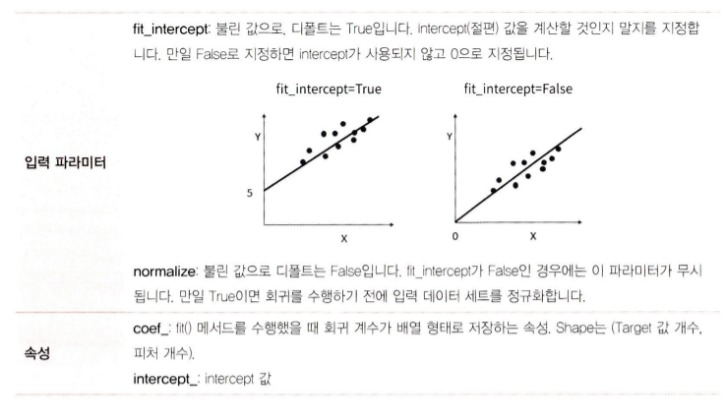

* OLS 기반의 회귀 계수 계산은 입력 피처의 독립성에 많은 영향을 받음
* 다중 공산성(multi-collinearity) 문제: 피처간의 상관관계가 매우 높은 경우 분산이 매우 커져서 오류에 매우 민감해짐
* 상관관계가 높은 피처가 많은 경우 독립적인 중요한 피처만 남기고 제거하거나 규제를 적용함
* 매우 많은 피처가 다중 공산성 문제를 가지고 있다면 PCA를 통해 차원 축소를 수행

In [4]:
#class sklearn.linear_model.LinearRegression(fit_intercept = True, normalize = False, copy_X = True, n_jobs = 1)

회귀 평가 지표
* 실제 값과 회귀 예측값의 차이 값을 기반으로 한 지표가 중심
* 실제값과 예측값의 차이를 그냥 더하면 +와 -가 섞여서 오류가 상쇄됨
* 오류의 절댓값 평균이나 제곱, 또는 제곱한 뒤 다시 루트를 씌운 평균값을 구함
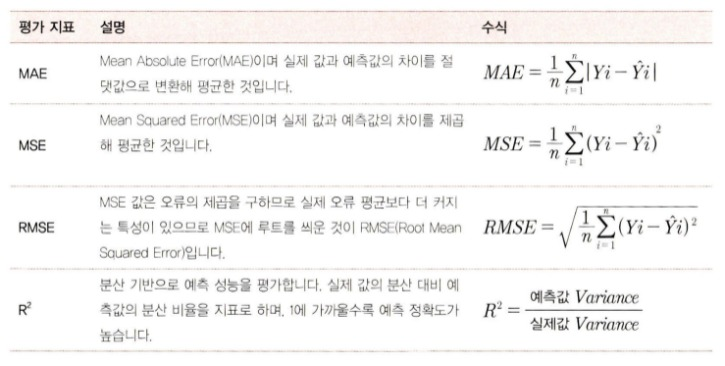

* 사이킷런은 RMSE를 제공하지 않아, MSE에 제곱근을 씌워서 계산하는 함수를 직접 만들어야 함
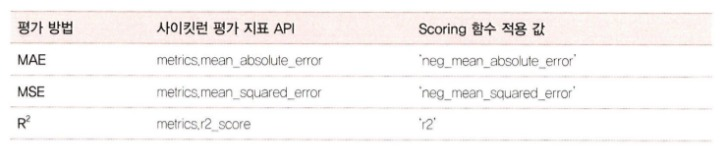

* cross_val_score, GridSearchCV와 같은 Scoring 함수에 회귀 평가 지표를 적용할 때 유의할 점
 * MAE의 scoring 파라미터 값은 neg_mean_absolut_error와 같이 "neg_"라는 접두어가 붙어 있음. 이는 음수값을 가진다는 의미인데, MAE는 절댓값의 합이기 때문에 음수가 될 수 없음. 
 * 실제 값과 예측 값의 오류 차이를 기반으로 하는 회귀 평가 지표의 경우 값이 커지면 오히려 나쁜 모델이라는 의미이므로 이를 사이킷런의 Scoring 함수에 일반적으로 반영하려면 보정이 필요함
 * 따라서 -1을 원래의 평가 지표 값에 곱해서 음수를 만들어 작은 오류 값이 더 큰 숫자로 인식하게 함
 * Scoring 함수의 scoring파라미터 값 "neg_mean_absolute_erorr"가 의미하는 것은 -1*metrics, mean_absolute_error()이니 주의해야 함

LinearRegression을 이용해 보스턴 주택 가격 회귀 구현 
* 보스턴 주택 가격 데이터의 피처 설명
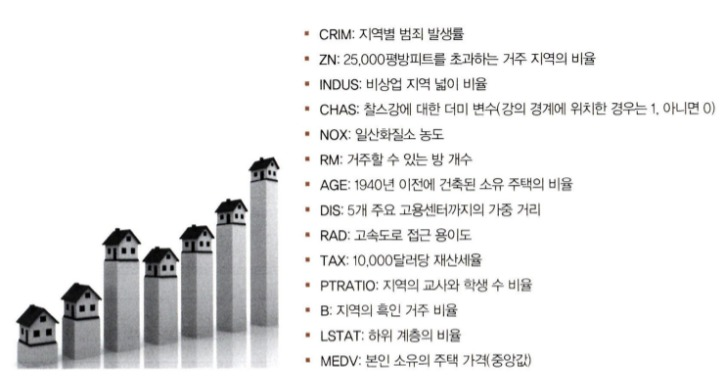


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
%matplotlib inline

# boston 데이터 세트 로드
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

# boston 데이터 세트 DataFrame 변환
bostonDF = pd.DataFrame(data, columns = feature_names)

# boston 데이터 세트의 target 배열은 주택 가격임. 이를 PRICE 칼럼으로 DataFrame에 추가함.
bostonDF["PRICE"] = target
print("Boston 데이터 세트 크기: ", bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기:  (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [12]:
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


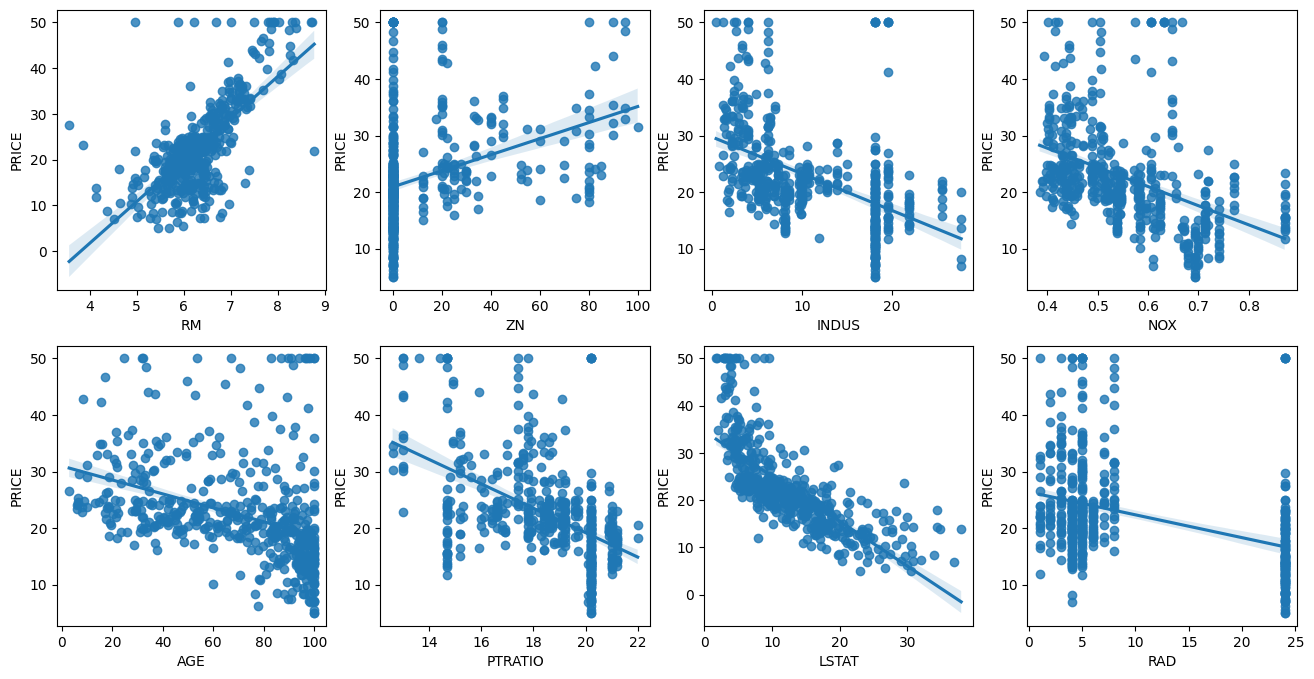

In [15]:
# 2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4x2개의 ax를 가짐.
fig, axs = plt.subplots(figsize = (16, 8), ncols = 4, nrows= 2)
lm_features = ["RM", "ZN", "INDUS", "NOX", "AGE", "PTRATIO", "LSTAT", "RAD"]
for i, feature in enumerate(lm_features):
  row = int(i / 4)
  col = i % 4
  # 시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
  sns.regplot(x = feature, y = "PRICE", data = bostonDF, ax = axs[row][col])

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF["PRICE"]
X_data = bostonDF.drop(["PRICE"], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.3,
                                                    random_state = 156)

# 선형 회귀 OLS로 학습/예측/평가 수행.
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print("MSE: {0:.3f}, RMSE: {1:.3F}".format(mse, rmse))
print("Variance score: {0:.3f}".format(r2_score(y_test, y_preds)))

MSE: 17.297, RMSE: 4.159
Variance score: 0.757


In [20]:
print("절편 값: ", lr.intercept_)
print("회귀 계수값: ", np.round(lr.coef_, 1))

절편 값:  40.995595172164826
회귀 계수값:  [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [21]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성. 인덱스 칼럼명에 유의
coeff = pd.Series(data = np.round(lr.coef_, 1), index = X_data.columns)
coeff.sort_values(ascending = False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [22]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF["PRICE"]
X_data = bostonDF.drop(["PRICE"], axis = 1, inplace = False)
lr = LinearRegression()

# cross_val_score()로 5 폴드 세트로 MSE를 구한 뒤 이를 기반으로 다시 RMSE 구함.
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring = "neg_mean_squared_error", cv = 5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring = "neg_mean_squared_error")로 반환된 값은 모두 음수
print("5 folds의 개별 Negative MSE scores; ", np.round(neg_mse_scores, 2))
print("5 folds의 개별 RMSE scores: ", np.round(rmse_scores, 2))
print("5 folds의 평균 RMSE: {0:.3f}".format(avg_rmse))

5 folds의 개별 Negative MSE scores;  [-12.46 -26.05 -33.07 -80.76 -33.31]
5 folds의 개별 RMSE scores:  [3.53 5.1  5.75 8.99 5.77]
5 folds의 평균 RMSE: 5.829
